In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

## Load data

In [2]:
# Load inferred cluster annotations 
annotation = pd.read_csv('GSE89567_batchcorrected_annotation_in_leiden.csv', 
                         delimiter=',', 
                         index_col=[0])
annotation['batch'] = annotation['batch'].apply(lambda x: x.strip('_'))
annotation.head()

,batch,n_genes,leiden
MGH42_P7_A01,MGH42,14383,Macrophage1
MGH42_P7_A02,MGH42,13770,Macrophage1
MGH42_P7_A03,MGH42,14903,Transformed1
MGH42_P7_A04,MGH42,14319,Macrophage1
MGH42_P7_A05,MGH42,14302,Transformed1


In [4]:
raw_counts = pd.read_csv('GSE89567_IDH_A_processed_data.txt.gz', 
                         compression='gzip', 
                         sep='\t', 
                         index_col=0)
raw_counts.index = [gene.strip("'") for gene in raw_counts.index]
raw_counts.head()

,MGH42_P7_A01,MGH42_P7_A02,MGH42_P7_A03,MGH42_P7_A04,MGH42_P7_A05,MGH42_P7_A07,MGH42_P7_A09,MGH42_P7_A11,MGH42_P7_A12,MGH42_P7_B02,...,MGH107neg_P2_E06,MGH107pos_P2_B03,MGH107neg_P1_F03,MGH107neg_P1_G06,MGH107neg_P2_H03,MGH107neg_P2_C05,MGH107pos_P2_D07,MGH107neg_P1_E01,MGH107pos_P2_G09,MGH107neg_P1_D06
A1BG,1.1928,0.000000,0.00000,0.0000,0.0000,0.66903,0.00000,0.0000,0.0000,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.00000,0.0000,2.4772,0.0000,0.0
A1BG-AS1,0.0000,0.000000,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.83996,0.0000,0.0000,0.0000,0.0
A1CF,0.0000,0.094912,0.00000,0.0000,0.0000,0.00000,0.00000,0.0000,0.0000,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0
A2M,7.0439,7.609500,0.77062,7.6146,0.0000,0.00000,0.27501,8.1624,6.5655,6.9658,...,0.0,8.6046,0.0,0.0,0.0,0.00000,9.5281,0.0000,6.8999,0.0
A2M-AS1,0.0000,0.000000,0.00000,0.0000,2.0339,2.39420,0.00000,0.0000,0.0000,0.0000,...,0.0,0.0000,0.0,0.0,0.0,0.00000,0.0000,0.0000,0.0000,0.0


In [9]:
# Load filtered, global-normalized, and batched-corrected expression matrix
mtx = pd.read_csv('GSE89567_batchcorrected_normalized.csv.gz',
                  compression='gzip', 
                  index_col=[0])

# Reformat mtx: tranpose to cell x gene; remove all '' in gene names
mtx = mtx.transpose()
mtx.index.name = 'Cell_ID'
mtx.columns = [gene.strip("'") for gene in mtx.columns]
mtx.head()

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Cell_ID,,,,,,,,,,,,,,,,,,,,,
MGH42_P7_A01,1.187306,0.012710,-0.004258,6.049037,-0.039227,-0.007474,-0.006710,0.000170,-0.003314,0.132913,...,-0.081958,-0.061733,-0.033487,0.120649,0.394543,0.015051,0.228959,2.849762,0.665783,0.172060
MGH42_P7_A02,-0.026585,0.013485,0.103494,6.974504,-0.041620,-0.007930,-0.007119,0.000181,-0.003516,0.141021,...,0.199992,-0.065499,-0.035530,0.010998,0.610772,0.457398,0.437343,2.302114,1.241416,0.182556
MGH42_P7_A03,-0.016561,0.008401,-0.002814,0.153306,-0.025927,0.185482,-0.004435,0.000112,-0.002190,2.032715,...,0.239227,2.073560,-0.022133,1.666270,0.718609,0.362348,2.151582,-0.149764,-0.113520,3.089583
MGH42_P7_A04,-0.023655,0.011999,-0.004019,6.210234,-0.037032,0.439550,-0.006334,0.000161,-0.003128,0.125477,...,-0.077373,0.506154,-0.031614,0.009786,1.052911,0.173726,1.429455,3.914058,-0.162144,0.162434
MGH42_P7_A05,-0.017968,0.009114,-0.003053,-0.346092,1.378180,0.213175,-0.004811,0.000122,-0.002376,1.789374,...,-0.058771,-0.044268,-0.024013,0.007433,2.533618,0.393123,3.021277,2.957805,1.182362,4.843932


## Get sets of "expressed genes"

From the suggestion from NicheNet Vignette, define "expressed genes" as genes with at least 10% non-zero counts (zero counts should not be more than 90% among cells for "expressed genes"):

"For single-cell data generated by the 10x platform in our lab, we consider genes to be expressed in a cell type when they have non-zero values in at least 10% of the cells from that cell type."

We obtain 4 different sets of expressed genes, one for each cell type respectively.
E.g. there are 701 cells in cluster Macrophage1, so we filtered out all genes having at least 71 non-zero expression counts (raw UMI counts) in this cluster as the "expressed genes in Macrophage1.

In [5]:
annotation.groupby('leiden').count()['batch']

leiden
Macrophage1      701
Macrophage2      308
Transformed1    5231
Transformed2     101
Name: batch, dtype: int64

In [11]:
# UPDATE raw_counts
raw_counts = raw_counts.transpose()
raw_counts.index.name = 'Cell_ID'

In [12]:
# double-check that the preprocessing didn't filter out cells and that the UMI order doesn't change
assert raw_counts.shape[0] == mtx.shape[0], "Cells filtered out during preprocessing"

In [13]:
assert np.array_equal(mtx.index, annotation.index), "Inconsistency between mtx and annotation indexes"

In [14]:
assert np.array_equal(raw_counts.index, mtx.index), "Inconsistance between raw_counts and mtx indexes"

In [15]:
# UDPATE raw_counts
raw_counts['Cluster_ID'] = annotation['leiden']
raw_counts.set_index('Cluster_ID', append=True, inplace=True)
raw_counts.head()

,,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AA06,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Cell_ID,Cluster_ID,,,,,,,,,,,,,,,,,,,,,
MGH42_P7_A01,Macrophage1,1.1928,0.0,0.000000,7.04390,0.0000,0.00000,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.0,0.090853,0.23879,0.00000,0.27143,2.7058,0.7137,0.0000
MGH42_P7_A02,Macrophage1,0.0000,0.0,0.094912,7.60950,0.0000,0.00000,0.0,0.0,0.0,0.0,...,0.26183,0.00000,0.0,0.000000,0.37518,0.37072,0.44467,2.1077,1.1434,0.0000
MGH42_P7_A03,Transformed1,0.0000,0.0,0.000000,0.77062,0.0000,0.19535,0.0,0.0,0.0,0.0,...,0.42975,3.14010,0.0,2.068300,0.76043,0.47508,3.13260,0.0000,0.0000,3.3404
MGH42_P7_A04,Macrophage1,0.0000,0.0,0.000000,7.61460,0.0000,0.32077,0.0,0.0,0.0,0.0,...,0.00000,0.58688,0.0,0.000000,0.78157,0.15056,1.48650,3.8459,0.0000,0.0000
MGH42_P7_A05,Transformed1,0.0000,0.0,0.000000,0.00000,2.0339,0.20664,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.0,0.000000,2.60240,0.47508,4.03830,3.8272,1.5514,4.8840


In [16]:
def select_cluster_expr_genes(df, filtered_genes, ratio=0.1):
    # default ratio=0.1 is to select the genes with at least 10% non-zero counts
    unique_cluster_labels = np.unique(df.index.get_level_values('Cluster_ID'))
    df = df[filtered_genes] # select intersection of genes from the preprocessing
    
    # Find the minimum number of expressed genes across all clusters
    expr_genes = {}
    min_num_expr_genes = df.shape[1]
    for label in unique_cluster_labels:
        df_subset = df.loc[df.index.get_level_values('Cluster_ID') == label]
        num_cells = df_subset.shape[0]
        ordered_expr_genes = df_subset.apply(
            lambda x: (x > 0).sum() / num_cells).sort_values(ascending=False)
        min_num_expr_genes = min(min_num_expr_genes, (ordered_expr_genes > ratio).sum())
        expr_genes[label] = ordered_expr_genes
        
    # Select # min_num_expr_genes highly expressed genes associated with each cluster
    expr_genes_df = pd.DataFrame({
        'Macrophage1': expr_genes['Macrophage1'][:min_num_expr_genes].index,
        'Macrophage2': expr_genes['Macrophage2'][:min_num_expr_genes].index,
        'Transformed1': expr_genes['Transformed1'][:min_num_expr_genes].index,
        'Transformed2': expr_genes['Transformed2'][:min_num_expr_genes].index
    })    
    
    return expr_genes_df

In [17]:
expr_genes_df = select_cluster_expr_genes(raw_counts, mtx.columns)
expr_genes_df.head()

,Macrophage1,Macrophage2,Transformed1,Transformed2
0,MTRNR2L6,LPP,GAPDH,YWHAE
1,RPL10,RPL15,MTRNR2L1,L2HGDH
2,MTRNR2L1,RPL19,EEF1A1,LOC100131257
3,ACTB,ACTB,ACTB,EIF1
4,MTRNR2L10,H3F3B,MTRNR2L8,TF


In [18]:
# expr_genes_df.to_csv('GSE89567_batchcorrected_expressed_genes.csv', 
#                      index=False, header=True)

## Get marker genes for each cluster

In [19]:
# convert to anndata
adata_mtx = sc.AnnData(mtx)
adata_mtx.obs['Cluster_ID'] = annotation['leiden'].astype('category')
adata_mtx.obs

,Cluster_ID
Cell_ID,
MGH42_P7_A01,Macrophage1
MGH42_P7_A02,Macrophage1
MGH42_P7_A03,Transformed1
MGH42_P7_A04,Macrophage1
MGH42_P7_A05,Transformed1
...,...
MGH107neg_P2_C05,Transformed1
MGH107pos_P2_D07,Macrophage1
MGH107neg_P1_E01,Transformed1


/home/myp2113/.local/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:408: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


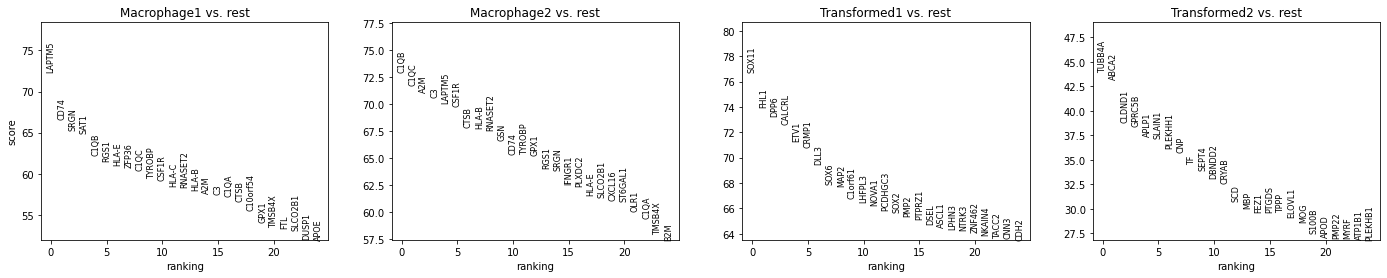

,Macrophage1,Macrophage2,Transformed1,Transformed2
0,LAPTM5,C1QB,SOX11,TUBB4A
1,CD74,C1QC,FHL1,ABCA2
2,SRGN,A2M,DPP6,CLDND1
3,SAT1,C3,CALCRL,GPRC5B
4,C1QB,LAPTM5,ETV1,APLP1
5,RGS1,CSF1R,CRMP1,SLAIN1
6,HLA-E,CTSB,DLL3,PLEKHH1
7,ZFP36,HLA-B,SOX6,CNP
8,C1QC,RNASET2,MAP2,TF
9,TYROBP,GSN,C1orf61,SEPT4


In [20]:
# t-test is used because data is already normalized
# and it was shown previously that t-test performs better
# than non-parametric test
sc.tl.rank_genes_groups(adata_mtx, 
                        groupby='Cluster_ID', 
                        method='t-test', 
                        n_genes=adata_mtx.shape[1])
sc.pl.rank_genes_groups(adata_mtx, n_genes=25, sharey=False)
pd.DataFrame(adata_mtx.uns['rank_genes_groups']['names']).head(20)

These "Marker genes" will be used as the "gene of interests" for NicheNet, they are the most differently expressed genes (DEGs) with regard to each cluster.

In [21]:
# marker_genes_df = pd.DataFrame(
#     adata_mtx.uns['rank_genes_groups']['names']).head(100)
# marker_genes_df.to_csv('GSE89567_batchcorrected_cluster_marker_genes.csv', 
#                        index=False,header=True)

## Save the batch corrected and normalized matrix in a file with the additional "Cluster_ID" column

In [22]:
# # save the batch corrected and normalized matrix finally
# # this takes some time
# mtx['Cluster_ID'] = annotation['leiden']  # notice mtx is updated here
# mtx.to_csv('GSE89567_batchcorrected_normalized_with_clusterID.csv.gz', 
#            index=True, 
#            header=True,
#            compression='gzip')